## Импорт, преобразование данных и предварительный анализ

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
prod = pd.read_csv('data/clay_bricks.csv', index_col=0, parse_dates=True)
prod.columns = ['million_units']

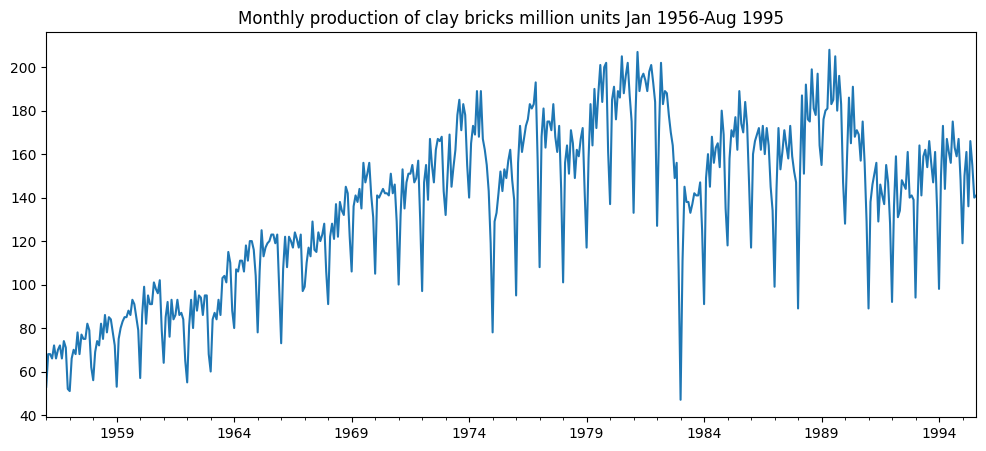

In [12]:
prod['million_units'].plot(figsize=(12,5))
plt.title('Monthly production of clay bricks million units Jan 1956-Aug 1995')
plt.show()

Возьмем значения с 1975 года, т.к. все что было до этого момента - не актуально

In [13]:
prod = prod['1975-01-01'::]

## Определение параметров модели SARIMA(p, d, q)x(P, D, Q) для данного ряда

Сначала определим параметры d и D для модели SARIMA с помощью критерия Дики-Фуллера

In [14]:
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller, kpss

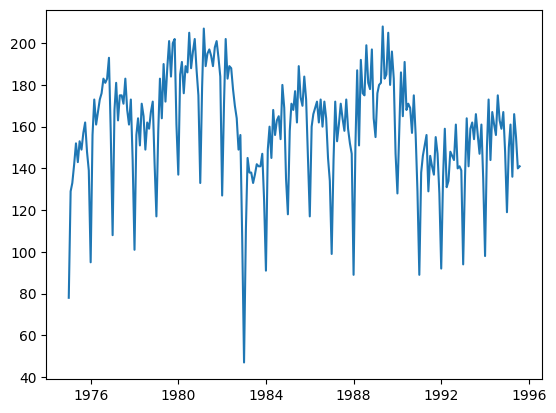

In [15]:
plt.plot(prod['million_units'])

In [21]:
y_transformation = pd.DataFrame(prod['million_units'].values, columns=['initial'])
y_transformation['seasonal_diff'] = y_transformation['initial'].diff(12)

In [27]:
print("Критерий Дики-Фуллера для исходного ряда с 1975 года: p=%f" % adfuller(y_transformation['initial'])[1])
print("Критерий Дики-Фуллера для исходного ряда с 1975 года: p=%f" % adfuller(y_transformation['seasonal_diff'].dropna())[1])

Критерий Дики-Фуллера для исходного ряда с 1975 года: p=0.000510
Критерий Дики-Фуллера для исходного ряда с 1975 года: p=0.004214


### Критерий Дики-Фуллера уже для исходного ряда дает p_value < 0.05, т.е. d = D = 0

Далее определим параметры q и Q с помощью коррелограммы

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

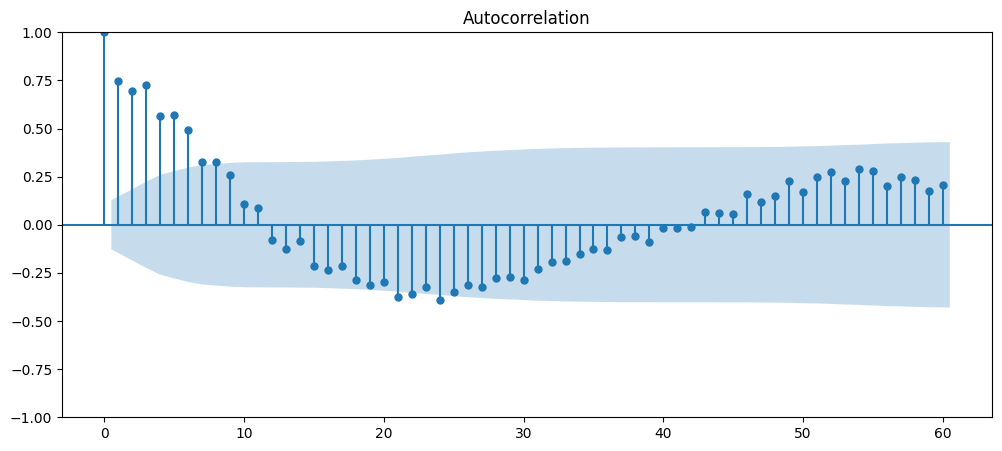

In [34]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(y_transformation['seasonal_diff'].dropna(), lags=60, ax=ax)
plt.show()

### Последний значимый лаг автокорреляции = 8 => $q_0=8$

### Последний значимый сезонный лаг автокорреляции = 0 => $Q_0=0$

Осталось определить параметры p и P с помощью частной корреляции

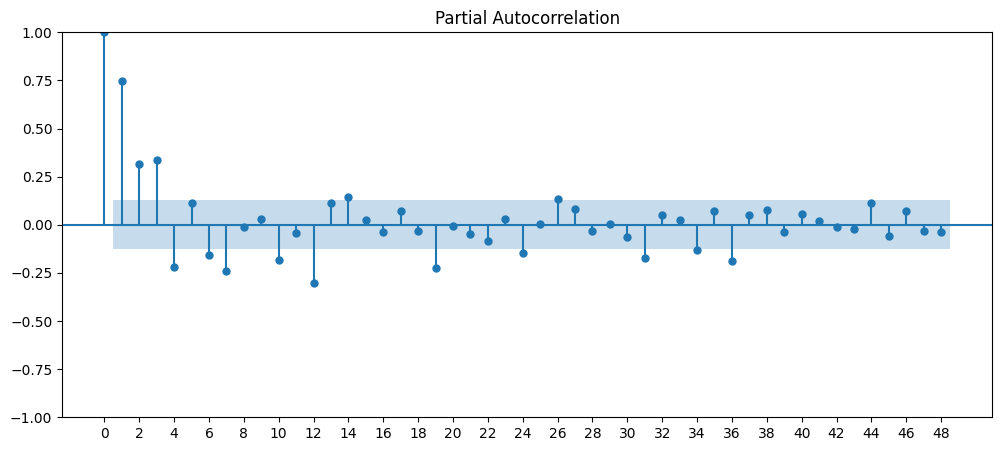

In [36]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(y_transformation['seasonal_diff'].dropna(), lags=48, method='ywm')
plt.xticks(np.arange(0, 50, 2))
plt.show()

### Последний значимый лаг = 4 => $p_0=4$

### При лаге 36 автокорреляция значима, однако слишком высокий порядок авторегрессии выбирать не рекомендуется. Возьмем $P_0=3$.

## Построение модели SARIMA с определенными параметрами и прогноза

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [53]:
model = SARIMAX(prod['million_units'],
                order=(4, 0, 6),
                seasonal_order=(3, 1, 0, 12)).fit()

c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
model.aic

1762.4660715114037

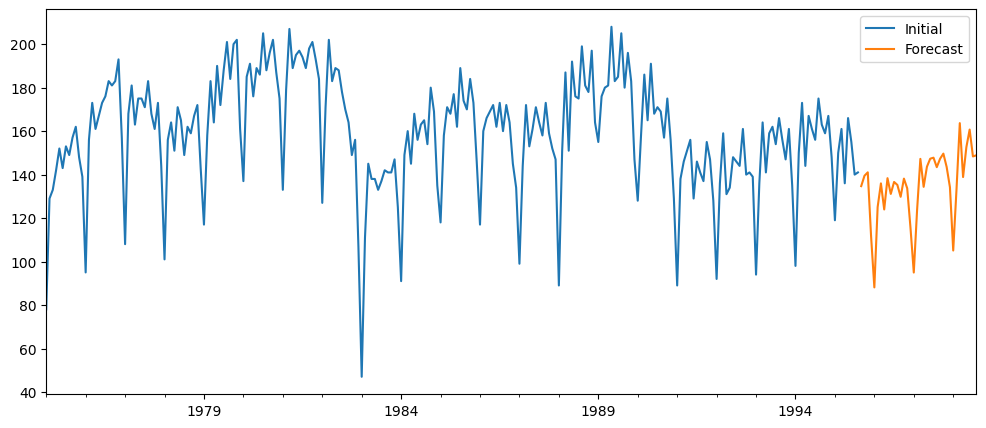

In [55]:
prod['million_units'].plot(figsize=(12,5))
model.forecast(36).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()

## Рассмотрение гиперпараметров в окрестностях начальных приближений

In [59]:
p = range(4, 7)
q = range(7, 9)
P = range(1, 4)
Q = range(0, 2)
d = 0
D = 1

In [60]:
from itertools import product

In [62]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [63]:
prod.index = pd.DatetimeIndex(prod.index.values,
                               freq=prod.index.inferred_freq)

In [64]:
old_aic = 100000
res_p = 0
res_q = 0
res_P = 0
res_Q = 0
for p, q, P, Q in parameters_list:
    model = SARIMAX(prod['million_units'],
                    order=(p, d, q), 
                    seasonal_order=(P, D, Q, 12), method_kwargs={"warn_convergence": False}).fit()
    cur_aic = model.aic
    print(cur_aic)
    if cur_aic < old_aic:
        res_p = p
        res_q = q
        res_P = P
        res_Q = Q
        old_aic = cur_aic

c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1789.3433919658569


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1741.108976323918


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1768.1702800353764


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1743.0462703889652


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1764.6112936119662


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1745.221851446265


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1790.2471984579665


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1741.8962397009973


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1767.5118192505397


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1743.638471990416


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1763.3072112062414


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1745.5168720314382


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1789.4037533709768


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1742.774294566629


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1770.1801896144998


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1744.8909719531239


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1766.0688802331592


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1747.1896811389138


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1791.385845630778


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1743.5558986190435


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1771.4437021329095


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1746.012661084703


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1766.5714606666395


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1747.8604914276575


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1787.8575831517492


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1743.0102840022819


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1771.5012190903153


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1747.045887097935


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1768.6930721186488


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1749.5030467987428


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1789.4214351390062


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1747.357197758533


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1773.8845418725573


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1749.2679490015744


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1770.1520854621458


c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1751.1019045850571


In [65]:
print(res_p, res_q, res_P, res_Q)

4 7 1 1


In [66]:
model = SARIMAX(prod['million_units'],
                order=(res_p, d, res_q), 
                seasonal_order=(res_P, D, res_Q, 12)).fit()

c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [67]:
model.aic

1741.108976323918

In [68]:
model.params

ar.L1        0.762599
ar.L2        0.286904
ar.L3        0.831802
ar.L4       -0.917972
ma.L1       -0.281567
ma.L2       -0.259600
ma.L3       -0.672178
ma.L4        0.450239
ma.L5        0.161101
ma.L6       -0.178432
ma.L7        0.054346
ar.S.L12     0.100295
ma.S.L12    -0.980611
sigma2      71.090826
dtype: float64

In [69]:
# почему ниже такие маленькие значения - непонятно

In [70]:
model.fittedvalues

1975-01-01      0.000000
1975-02-01      0.032490
1975-03-01      0.084630
1975-04-01      0.138455
1975-05-01      0.191072
                 ...    
1995-04-01    159.325945
1995-05-01    164.166657
1995-06-01    149.818212
1995-07-01    157.622910
1995-08-01    156.195342
Freq: MS, Length: 248, dtype: float64

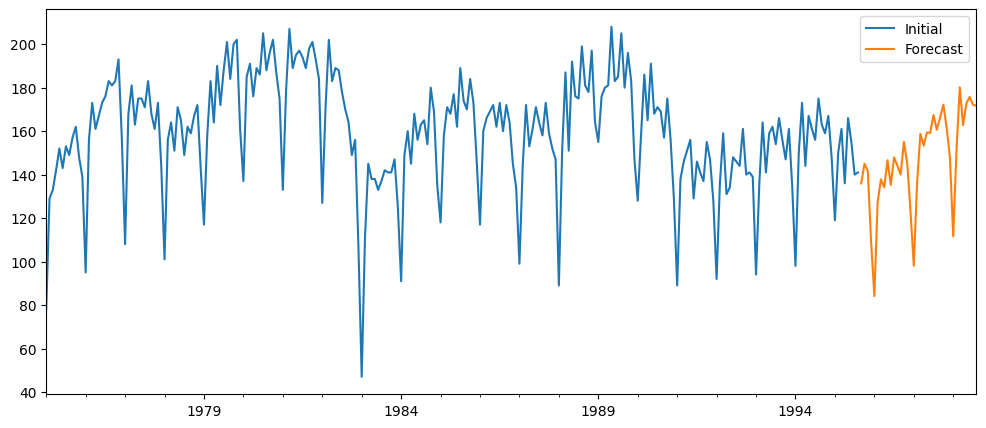

In [72]:
prod['million_units'].plot(figsize=(12,5))
model.forecast(36).plot()
plt.legend(['Initial', 'Forecast'])
plt.show()
# ????????????????????????????????????